## <center>HRRR PWV and Sentinel-1 Unwrpped phase analysis<center>

This notebook demonstrates the HRRR precipitable water field (3km horizontal resolution) and also the comparison between column-integrated water vapor and retrieved Sentinel-1 inteferograms which are subject to variations of water vapor within the troposphere. The objective of this notebook is trying to building the statistical relationship between these two datasets. 

<center>Wei-Ming Tsai, Sept 2018<center>

In [1]:
import sys
from datetime import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pygrib 

### InSAR datasets: checking variables and I/O

In [2]:
os.chdir('/Users/willy/Desktop/UMworks/')

In [3]:
# Reading ifgramStack.h5 and geometryRadar.h5 processed by ISCE
import h5py
filename = 'ifgramStack.h5'
data = h5py.File(filename, 'r')

for key in data.keys():
    print(key) #Names of the groups in HDF5 file.

unwrap = data['unwrapPhase'];
#var_m = var_rad * (wavelength / (-4 * pi))
wavelength = 0.056 #[m] for Sentinel-1 
unwrap = unwrap.value*(wavelength/(-4*np.pi))*1000 # converting radian to millimeter

coherence = data['coherence'];
date = data['date'];
bperp = data['bperp']

bperp
coherence
connectComponent
date
dropIfgram
unwrapPhase


In [4]:
filename2 = 'geometryRadar.h5'
geo = h5py.File(filename2,'r')
for key in geo.keys():
    print(key) #Names of the groups in HDF5 file.
lat = geo['latitude'];
lon = geo['longitude'];
incidence = geo['incidenceAngle'];
axis_bound = [np.min(lat),np.max(lat),np.min(lon),np.max(lon)]; # coordinate bound [South,North,West,East]

azimuthAngle
height
incidenceAngle
latitude
longitude
shadowMask
slantRangeDistance


### InSAR frame times : selecting available inteferograms

In [5]:
frame_label = np.zeros((np.shape(date)[0],2))
frame_sel = []; frame_idx = [];
for i in range(np.shape(date)[0]):
    frame_label[i,0] = str(date.value[i,0])[2:10];frame_label[i,1]=str(date.value[i,1])[2:10]
    delta_day = datetime.strptime(str(frame_label[i,1])[0:8],'%Y%m%d') \
                - datetime.strptime(str(frame_label[i,0])[0:8],'%Y%m%d') # days between two acquisitions 
    if delta_day.days == 12: # days for a complte circle of orbiting 
        frame_sel += [[str(frame_label[i,0])[0:8],str(frame_label[i,1])[0:8]]]
        frame_idx = frame_idx + [i]; # index for available frames to be compared

Available acquisition time for two datasets:
[['20180421', '20180503'], ['20180527', '20180608'], ['20180608', '20180620'], ['20180620', '20180702']]


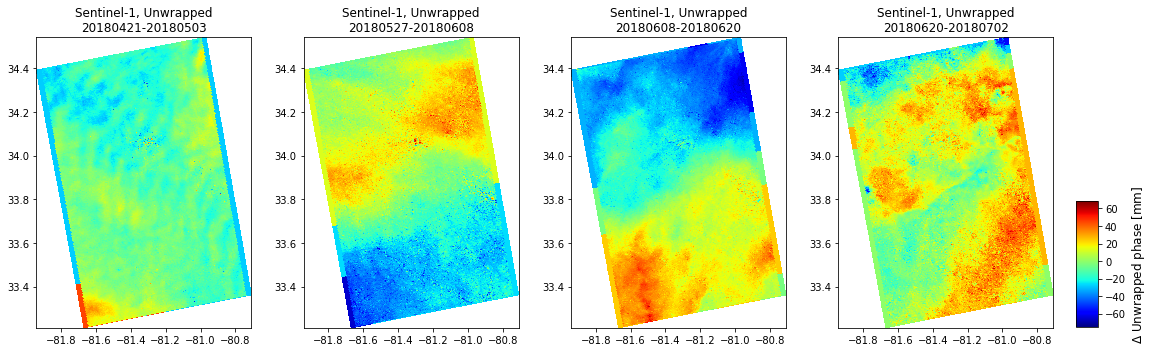

In [6]:
frame_sel=frame_sel[2:]
frame_sel=frame_sel[:4]
print('Available acquisition time for two datasets:');
print(frame_sel)

#========== plotting sections ==============
frame_num=np.shape(frame_sel)
[row,column]=np.divmod(frame_num[0],4)
if column == 0:
    row=row;
else:
    row=row+1;

i=1;
fig=plt.figure(figsize=(15,5))
for n in range(np.shape(frame_sel)[0]):
    plt.subplot(int(row),4,i)
    plt.pcolormesh(lon,lat,unwrap[frame_idx[n],:,:],cmap='jet',)
    plt.title('Sentinel-1, Unwrapped'+'\n'+ frame_sel[n][0] + '-' + frame_sel[n][1],fontsize=12)
#              'lat=' + str([axis_bound[0],axis_bound[1]]) + '  '
#              'lon=' + str([axis_bound[2],axis_bound[3]]),fontsize=11)
    i=i+1

plt.tight_layout()
cbaxes = fig.add_axes([1, 0.08, 0.02, 0.35]) # colorbar location
cb = plt.colorbar(cax = cbaxes)  
cb.set_label('$\Delta$'+' Unwrapped phase [mm]',fontsize=12)

### Selecting the nearest HRRR output for comparison, depending on the geolocation of frames
HRRR_PWV at valid time (with data assimulation only) is applied. The current area of InSAR frames is centered at Columbia, South Carolina

In [14]:
from datetime import timedelta

frame_HRRR=list(frame_sel)
UTC_sel = 23;
output_UTC=np.array([0,6,12,18,24]); # current downloaded HRRR
output_UTCstr=['00','06','12','18','24']; 

UTC_idx = (np.abs(output_UTC - UTC_sel)).argmin()

# if the acquisition time is close to the next day (24 UTC): replace frame_sel for HRRR
if UTC_idx == 4: 
    for idx, x in enumerate(frame_HRRR): 
        b=[datetime.strptime(date,'%Y%m%d') for date in x]
        b[0]+= timedelta(days=1)
        b[1]+= timedelta(days=1)

        frame_HRRR[idx]=[datetime.strftime(b[0],'%Y%m%d'),datetime.strftime(b[1],'%Y%m%d')]
    UTC_idx=0;
print('UTC_SAR:'+str(UTC_sel)+'z'+'    '+'UTC_HRRR:'+output_UTCstr[UTC_idx]+'z');print('')
print('Available SAR inteferograms:\n',frame_sel);print('')
print('Corresponding HRRR_PWV:\n',frame_HRRR)

UTC_SAR:23z    UTC_HRRR:00z

Available SAR inteferograms:
 [['20180421', '20180503'], ['20180527', '20180608'], ['20180608', '20180620'], ['20180620', '20180702']]

Corresponding HRRR_PWV:
 [['20180422', '20180504'], ['20180528', '20180609'], ['20180609', '20180621'], ['20180621', '20180703']]


In [15]:
os.chdir('/Users/willy/Desktop/UMworks/HRRR_PW_6hourly/')
grbs = pygrib.open('hrrr.t'+output_UTCstr[UTC_idx]+'z.'+str(frame_HRRR[2][0])+'.grib2')  
grb = grbs.read(1)[0] # read returns a list with the next N (N=1 in this case) messages

# reading grib2 data
lats, lons = grb.latlons() 
pw = grb.values
print(grb)
print('Nearest UTC:'+output_UTCstr[UTC_idx]+'Z')

1:Precipitable water:kg m**-2 (instant):lambert:unknown:level 0 considered as a single layer:fcst time 0 hrs:from 201806090000
Nearest UTC:00Z


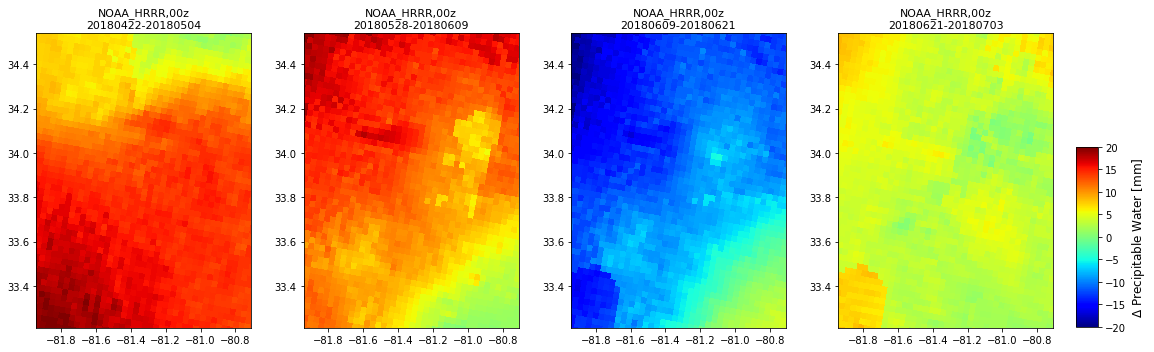

In [18]:
i=1;
fig = plt.figure(figsize=(15,5))
for date in frame_HRRR:
    
    grbs = pygrib.open('hrrr.t'+str(output_UTC[idx])+'z.'+ date[0] +'.grib2')  
    grb = grbs.read(1)[0] # read returns a list with the next N (N=1 in this case) messages
    pw = grb.values
    grbs2 = pygrib.open('hrrr.t'+str(output_UTC[idx])+'z.'+ date[1] +'.grib2')  
    grb2 = grbs2.read(1)[0] # read returns a list with the next N (N=1 in this case) messages
    lats, lons = grb2.latlons() 
    pw2 = grb2.values

    plt.subplot(int(row),4,i)
    plt.pcolormesh(lons,lats,pw-pw2,cmap='jet',vmin=-20,vmax=20)
    plt.axis([axis_bound[2], axis_bound[3], axis_bound[0], axis_bound[1]]) # axes corresponding to InSAR frames
    plt.title('NOAA_HRRR,'+output_UTCstr[UTC_idx]+'z'+'\n'+ date[0] + '-' +  date[1],fontsize=11)

    i=i+1

plt.tight_layout()
cbaxes = fig.add_axes([1, 0.08, 0.02, 0.5]) # colorbar location
cb = plt.colorbar(cax = cbaxes)  
cb.set_label('$\Delta$'+' Precipitable Water [mm]',fontsize=12)

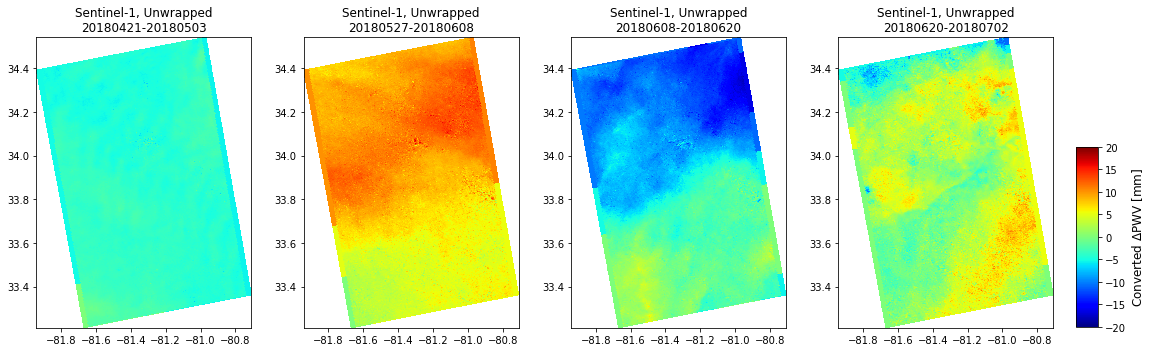

In [19]:
i=1;
fig=plt.figure(figsize=(15,5))
for n in range(np.shape(frame_sel)[0]):
    plt.subplot(1,4,i)
    # Barnhart and Lohman (2013)
    # D_wet = D_PWV x 6.4 x cos(incidence angle) => D_PWV
    plt.pcolormesh(lon,lat,unwrap[frame_idx[n],:,:]/(np.cos(incidence[:,:]/180*np.pi))/6.4,cmap='jet',
                  vmin=-20,vmax=20) 
                                                                                                        
    plt.title('Sentinel-1, Unwrapped'+'\n'+ frame_sel[n][0] + '-' + frame_sel[n][1],fontsize=12)
#              'lat=' + str([axis_bound[0],axis_bound[1]]) + '  '
#              'lon=' + str([axis_bound[2],axis_bound[3]]),fontsize=11)
    i=i+1

plt.tight_layout()
cbaxes = fig.add_axes([1, 0.08, 0.02, 0.5]) # colorbar location
cb = plt.colorbar(cax = cbaxes)  
cb.set_label('Converted $\Delta$'+'PWV [mm]',fontsize=12)